In [16]:
import os                     
import cv2                    
import numpy as np             
import pandas as pd           
from glob import glob          

from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt  
from torch.utils.data import DataLoader
import torch.optim as optim


# Define a custom Dataset for loading eye images and corresponding labels
class EyeDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=(224, 224), transform=None):
        """
        Args:
            image_dir (str): Path to directory containing .png image files.
            label_dir (str): Path to directory containing label CSV files.
            img_size (tuple): Size to which all images are resized. Standardizing size improves batch processing.
            transform (callable, optional): Transformations to apply for augmentation and normalization.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir

        # Collect and sort all image paths to align with label files
        self.img_paths = sorted(glob(os.path.join(image_dir, "*.png")))
        self.img_size = img_size

        # Define a comprehensive  tranfrosmation with augmentations
        # Reasoning: Helps generalize the model by simulating varied real-world conditions
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy array to PIL Image
            transforms.Resize(img_size), # Resize images to a consistent size
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),  # Randomize
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust brightness, contrast, and saturation
            transforms.RandomHorizontalFlip(),  # Randomly flip images
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Blur to simulate varied imaging conditions
            transforms.ToTensor(),  # Convert to PyTorch tensor
            transforms.Normalize([0.5]*3, [0.5]*3),  # Normalize to [-1, 1] range for better training stability
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Randomly erase parts of the image to improve robustness
        ])

    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
            Needed for PyTorch DataLoader to iterate correctly.
        """
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_h, original_w = image.shape[:2]  # <- needed for scaling

        if self.transform:
            image = self.transform(image)

        label_path = os.path.join(self.label_dir, img_name + ".csv")
        label_df = pd.read_csv(label_path)
        label = label_df.values.flatten().astype(np.float32)

        # Scale label coordinates to match the resized image
        scale_x = self.img_size[1] / original_w  # usually 224 / original width
        scale_y = self.img_size[0] / original_h  # usually 224 / original height

        label[0] *= scale_x  # pupil x
        label[1] *= scale_y  # pupil y
        label[2] *= scale_x  # pupil rx
        label[3] *= scale_y  # pupil ry
        # theta_p stays same

        label[5] *= scale_x  # iris x
        label[6] *= scale_y  # iris y
        label[7] *= scale_x  # iris rx
        label[8] *= scale_y  # iris ry
        # theta_i stays same

        return image, torch.tensor(label)



In [17]:
# Initialize the dataset and device
dataset = EyeDataset(
        image_dir="/Users/Standon/Downloads/CV-C3/training_set/images",
        label_dir="/Users/Standon/Downloads/CV-C3/training_set/groundtruth"
    )
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [18]:
def compute_metrics(preds, trues):
    """
    Compute evaluation metrics for pupil and iris predictions.

    Metrics:
        - % Y-diameter error: measures how far off the predicted vertical radius (diameter/2) is
        - Intersection-over-Union (IoU): compares predicted vs. true ellipse areas for overlap

    Args:
        preds (Tensor): Predicted outputs, shape (N, 10) – includes pupil and iris parameters
        trues (Tensor): Ground truth labels, shape (N, 10)

    Returns:
        Tuple of arrays: 
            pupil_dy_error: normalized absolute error for pupil Y-diameter
            iris_dy_error: normalized absolute error for iris Y-diameter
            pupil_iou: estimated IoU based on predicted vs. true ellipse area
            iris_iou: same for iris
    """
    # Convert to NumPy for easier manipulation
    preds = preds.cpu().numpy()
    trues = trues.cpu().numpy()

    # Compute % error in vertical diameter (Y-axis) for pupil and iris
    pupil_dy_error = np.abs(preds[:, 3] - trues[:, 3]) / np.clip(trues[:, 3], 1e-6, None)
    iris_dy_error = np.abs(preds[:, 8] - trues[:, 8]) / np.clip(trues[:, 8], 1e-6, None)

    mean_pupil_dy_error = np.mean(pupil_dy_error)
    mean_iris_dy_error = np.mean(iris_dy_error)

    # Define area of an ellipse
    def ellipse_area(rx, ry): return np.pi * rx * ry

    # Compute predicted and true ellipse areas
    pupil_pred_area = ellipse_area(preds[:, 2], preds[:, 3])
    pupil_true_area = ellipse_area(trues[:, 2], trues[:, 3])
    iris_pred_area = ellipse_area(preds[:, 7], preds[:, 8])
    iris_true_area = ellipse_area(trues[:, 7], trues[:, 8])

    # Estimate IoU by comparing areas directly
    pupil_inter = np.minimum(pupil_pred_area, pupil_true_area)
    pupil_union = np.maximum(pupil_pred_area, pupil_true_area)
    iris_inter = np.minimum(iris_pred_area, iris_true_area)
    iris_union = np.maximum(iris_pred_area, iris_true_area)

    pupil_iou = pupil_inter / pupil_union
    iris_iou = iris_inter / iris_union

    # Print evaluation summary
    print(f"Mean % Pupil Diameter Y Error: {mean_pupil_dy_error * 100:.2f}%")
    print(f"Mean % Iris Diameter Y Error:  {mean_iris_dy_error * 100:.2f}%")
    print(f"Mean Pupil IoU: {np.mean(pupil_iou) * 100:.2f}%")
    print(f"Mean Iris IoU:  {np.mean(iris_iou) * 100:.2f}%")

    return pupil_dy_error, iris_dy_error, pupil_iou, iris_iou


In [19]:
def visualize_predictions(dataset, model, device):
    """
    Visualize a few samples of predicted vs. true eye landmarks from the model.

    Purpose:
        - Useful for debugging and understanding qualitative model performance.
        - Allows you to directly compare the model's output to ground truth visually.

    Visualizations:
        - Green dot: true pupil center
        - Red dot: predicted pupil center
        - Cyan dot: true iris center
        - Magenta dot: predicted iris center
    """
    model.eval()  # Set model to evaluation mode

    # Create a small random sample of 4 images for visualization
    sample_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    with torch.no_grad():  # No gradient computation needed
        for i, (img, label) in enumerate(sample_loader):
            if i >= 4:  # Limit to 4 samples
                break

            img = img.to(device)
            output = model(img)  # Get model prediction
            output = torch.cat(output, dim=1).cpu().numpy().flatten()  # Flatten to 1D array
            label = label.numpy().flatten()

            # Undo normalization to restore original image for display
            img_np = img.cpu().squeeze().permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
            img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # Denormalize (assuming range was [-1, 1])

            # Display the image with landmark overlays
            plt.imshow(img_np)
            plt.scatter(label[0], label[1], c='g', label='True Pupil')
            plt.scatter(output[0], output[1], c='r', label='Pred Pupil')
            plt.scatter(label[5], label[6], c='c', label='True Iris')
            plt.scatter(output[5], output[6], c='m', label='Pred Iris')
            plt.legend()
            plt.axis('off')
            plt.show()


In [33]:

class EyeNet(nn.Module):
    """
    Deep CNN model for predicting pupil and iris ellipse parameters.
    Architecture includes a shared convolutional encoder followed by two separate fully connected heads 
    for multitask regression: one for pupil and one for iris.

    Each head predicts 5 parameters (e.g., center_x, center_y, radius_x, radius_y, angle).
    """

    def __init__(self):
        super(EyeNet, self).__init__()

        # Shared convolutional encoder (inspired by VGG-like architecture)
        # Reasoning: Deep stack of 3x3 convolutions preserves spatial resolution and extracts rich hierarchical features
        self.conv = nn.Sequential(
            # First block: input (3 channels RGB) → 64 feature maps
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Normalize feature maps for stable training
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2

            # Second block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Adaptive average pooling to compress spatial dimensions to 1x1
        # Reasoning: Global context + fixed feature length regardless of input size
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Shared fully connected layer before branching
        # Reasoning: Reduces 512-dim feature to 256, adds dropout for regularization
        self.shared_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Task-specific heads
        # Each head outputs 5 values (x, y, rx, ry, angle) for pupil and iris respectively
        self.pupil_head = nn.Linear(256, 5)
        self.iris_head = nn.Linear(256, 5)

    def forward(self, x):
        """
        Forward pass: extract features using conv layers,
        then use shared FC and two separate heads to predict pupil and iris parameters.

        Returns:
            pupil_pred (Tensor): shape [batch_size, 5]
            iris_pred (Tensor): shape [batch_size, 5]
        """
        x = self.conv(x)            # Shared CNN feature extractor
        x = self.gap(x)             # Global average pooling
        x = x.view(x.size(0), -1)   # Flatten to (batch_size, 512)
        x = self.shared_fc(x)       # Shared FC layer
        return self.pupil_head(x), self.iris_head(x)

    def num_parameters(self):
        """
        Returns:
            int: Total number of trainable parameters in the model.
            Useful for debugging or comparing model complexity.
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [35]:

# Create a DataLoader to iterate over the full dataset for final training
full_loader = DataLoader(dataset, batch_size=4, shuffle=True)

#Instantiate the EyeNet model and move it to the specified device (GPU or CPU)
final_model = EyeNet().to(device)

# Use SmoothL1Loss (Huber loss) which balances sensitivity to outliers and stability for regression
criterion = nn.SmoothL1Loss()

# AdamW optimizer is used here with weight decay for better generalization and preventing overfitting
optimizer = optim.AdamW(final_model.parameters(), lr=0.00007, weight_decay=1e-4)

# ReduceLROnPlateau dynamically lowers the learning rate when the validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Set training configuration
final_num_epochs = 30
patience = 5 # Early stopping after 3 epochs without improvement
epochs_no_improve = 0
best_final_loss = float("inf")  # Initialize with infinity so first epoch always improves
train_losses = []
lr_history = []
pupil_losses_epoch = []
iris_losses_epoch = []

# === Main Training Loop ===
for epoch in range(1, final_num_epochs + 1):
    final_model.train()  # Set model to training mode
    running_loss = 0.0
    preds_all, trues_all = [], []

    for batch_idx, (images, labels) in enumerate(full_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients

        # Forward pass through model: get predictions for pupil and iris
        pupil_out, iris_out = final_model(images)

        # Separate label tensors for pupil (first 5 values) and iris (last 5)
        pupil_labels = labels[:, :5]
        iris_labels = labels[:, 5:]

        # Compute loss for each task
        pupil_loss = criterion(pupil_out, pupil_labels)
        iris_loss = criterion(iris_out, iris_labels)

        # Weighted loss: prioritizing pupil prediction more if needed
        loss = 1.0 * pupil_loss + 1.0 * iris_loss

        # Store per-batch task-specific losses for plotting
        pupil_losses_epoch.append(pupil_loss.item())
        iris_losses_epoch.append(iris_loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Save predictions and ground truth for metrics
        outputs_concat = torch.cat([pupil_out, iris_out], dim=1)
        preds_all.append(outputs_concat.detach().cpu())
        trues_all.append(labels.detach().cpu())

        # Log progress every 20 batches
        if batch_idx % 20 == 0:
            print(f"Final Model | Epoch {epoch} | Batch {batch_idx+1}/{len(full_loader)}")

    # Calculate average loss for this epoch
    avg_loss = running_loss / len(full_loader)
    print(f"Epoch {epoch} Final Train Loss: {avg_loss:.4f}")

    # Evaluate model performance on training data
    compute_metrics(torch.cat(preds_all), torch.cat(trues_all))

    # Save training loss and current learning rate
    train_losses.append(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # Update learning rate scheduler
    scheduler.step(avg_loss)

    # Check for improvement and apply early stopping logic
    if avg_loss < best_final_loss:
        best_final_loss = avg_loss
        best_model_state = final_model.state_dict()  # Save best model weights
        epochs_no_improve = 0
        print("Final model improved. Saving.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping for final model.")
        break

# Save the best-performing model weights to disk
torch.save(best_model_state, "best_eye_model_full.pth")
print("Final model saved as best_eye_model_full.pth")


# Plot training loss curve across epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot learning rate history to visualize effect of LR scheduler
plt.subplot(1, 2, 2)
plt.plot(lr_history, marker='o', color='orange')
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.tight_layout()
plt.show()

# Plot per-task loss progression to analyze how pupil and iris predictions evolve
plt.figure(figsize=(10, 5))
plt.plot(pupil_losses_epoch, label="Pupil Loss", color='skyblue')
plt.plot(iris_losses_epoch, label="Iris Loss", color='orange')
plt.title("Per-Task Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/Standon/miniconda3/envs/CV_C3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Final Model | Epoch 1 | Batch 1/374
Final Model | Epoch 1 | Batch 21/374
Final Model | Epoch 1 | Batch 41/374
Final Model | Epoch 1 | Batch 61/374
Final Model | Epoch 1 | Batch 81/374
Final Model | Epoch 1 | Batch 101/374
Final Model | Epoch 1 | Batch 121/374
Final Model | Epoch 1 | Batch 141/374
Final Model | Epoch 1 | Batch 161/374
Final Model | Epoch 1 | Batch 181/374
Final Model | Epoch 1 | Batch 201/374
Final Model | Epoch 1 | Batch 221/374
Final Model | Epoch 1 | Batch 241/374
Final Model | Epoch 1 | Batch 261/374
Final Model | Epoch 1 | Batch 281/374
Final Model | Epoch 1 | Batch 301/374
Final Model | Epoch 1 | Batch 321/374
Final Model | Epoch 1 | Batch 341/374
Final Model | Epoch 1 | Batch 361/374
Epoch 1 Final Train Loss: 68.4357
Mean % Pupil Diameter Y Error: 46.70%
Mean % Iris Diameter Y Error:  41.28%
Mean Pupil IoU: 44.44%
Mean Iris IoU:  48.95%
Final model improved. Saving.
Final Model | Epoch 2 | Batch 1/374
Final Model | Epoch 2 | Batch 21/374
Final Model | Epoch 2 | B

/var/folders/f9/gyk3rqcn7mx47nrj53xn42000000gn/T/ipykernel_36075/519079402.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_eye_mo

Mean % Pupil Diameter Y Error: 43.61%
Mean % Iris Diameter Y Error:  28.29%
Mean Pupil IoU: 60.02%
Mean Iris IoU:  64.42%


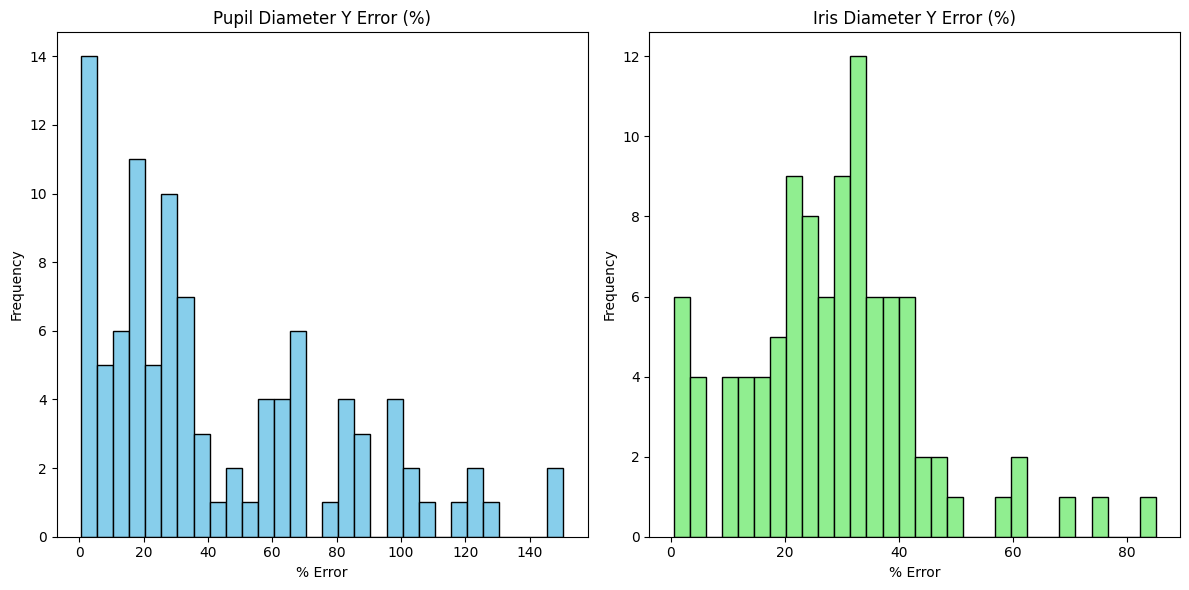

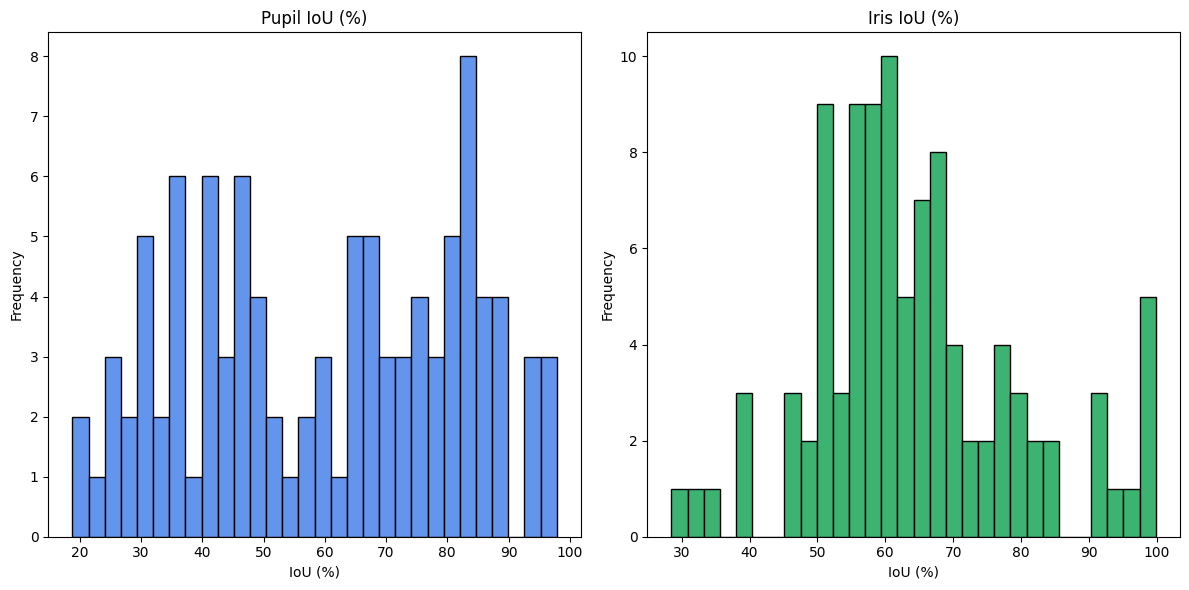

In [ ]:
if __name__ == "__main__":
    # Load the test dataset using the same preprocessing pipeline as training,
    # ensuring consistency in input format and normalization
    test_dataset = EyeDataset(
        image_dir="/Users/Standon/Downloads/CV-C3/testing_set/images",
        label_dir="/Users/Standon/Downloads/CV-C3/testing_set/groundtruth",
        transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),  # Resize to match model input size
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
        ])
    )

    # Create DataLoader to iterate through the test data without shuffling
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Load the best model
    model = EyeNet().to(device)
    model.load_state_dict(torch.load("best_eye_model_full.pth"))
    model.eval()

    all_preds = []
    all_trues = []

    # Disable gradient tracking to save memory and computation during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Forward pass to obtain model predictions
            pupil_out, iris_out = model(images)

            # Concatenate pupil and iris predictions for unified metric evaluation
            outputs_concat = torch.cat([pupil_out, iris_out], dim=1)
            all_preds.append(outputs_concat.cpu())
            all_trues.append(labels.cpu())

    # Compute key evaluation metrics: diameter errors and ellipse area IoUs
    pupil_err, iris_err, pupil_iou, iris_iou = compute_metrics(
        torch.cat(all_preds), torch.cat(all_trues)
    )

    # Plot histograms to visualize prediction errors for pupil and iris diameters
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(pupil_err * 100, bins=30, color='skyblue', edgecolor='black')
    plt.title("Pupil Diameter Y Error (%)")
    plt.xlabel("% Error")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(iris_err * 100, bins=30, color='lightgreen', edgecolor='black')
    plt.title("Iris Diameter Y Error (%)")
    plt.xlabel("% Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot histograms of Intersection-over-Union (IoU) to evaluate shape overlap accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(pupil_iou * 100, bins=30, color='cornflowerblue', edgecolor='black')
    plt.title("Pupil IoU (%)")
    plt.xlabel("IoU (%)")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(iris_iou * 100, bins=30, color='mediumseagreen', edgecolor='black')
    plt.title("Iris IoU (%)")
    plt.xlabel("IoU (%)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [ ]:

# Compute mean values
mean_pupil_error = pupil_err.mean() * 100
mean_iris_error = iris_err.mean() * 100
mean_pupil_iou = pupil_iou.mean() * 100
mean_iris_iou = iris_iou.mean() * 100

# Create a dictionary of metrics
metrics_dict = {
    "Metric": [
        "Mean % Pupil Diameter Y Error",
        "Mean % Iris Diameter Y Error",
        "Mean Pupil IoU",
        "Mean Iris IoU"
    ],
    "Value (%)": [
        f"{mean_pupil_error:.2f}",
        f"{mean_iris_error:.2f}",
        f"{mean_pupil_iou:.2f}",
        f"{mean_iris_iou:.2f}"
    ]
}

df_metrics = pd.DataFrame(metrics_dict)

# Save to CSV
df_metrics.to_csv("evaluation_metrics.csv", index=False)



In [ ]:


def run_inference(model_path, test_image_dir, test_label_dir, device=None):
    """
    Loads a trained model and evaluates it on the test set.
    
    Args:
        model_path (str): Path to the saved model (.pth file)
        test_image_dir (str): Directory containing test images
        test_label_dir (str): Directory containing ground truth CSVs
        device (str or None): Device to run the model on ("cuda", "cpu", or None for auto-detect)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define preprocessing transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Create test dataset and DataLoader
    test_dataset = EyeDataset(test_image_dir, test_label_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Load trained model
    model = EyeNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval() 

    all_preds, all_trues = [], []

    # Disable gradient computation for faster inference
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Get model predictions
            pupil_out, iris_out = model(images)
            outputs_concat = torch.cat([pupil_out, iris_out], dim=1)
            
            # Store predictions and ground truths
            all_preds.append(outputs_concat.cpu())
            all_trues.append(labels.cpu())

    # Concatenate results and compute evaluation metrics
    preds, trues = torch.cat(all_preds), torch.cat(all_trues)
    compute_metrics(preds, trues)


#!!!!!!!!!! insert hidden set below !!!!!!!
'''
# Entry point for script execution
if __name__ == "__main__":
    run_inference(
        model_path="best_eye_model_full.pth",
        test_image_dir="PATH/TO/test/images",           # <- Replace with actual path
        test_label_dir="PATH/TO/test/groundtruth"       # <-  Replace with actual path
    )
'''

'\n# Entry point for script execution\nif __name__ == "__main__":\n    run_inference(\n        model_path="best_eye_model_full.pth",\n        test_image_dir="PATH/TO/test/images",           # <- Replace with actual path\n        test_label_dir="PATH/TO/test/groundtruth"       # <-  Replace with actual path\n    )\n'

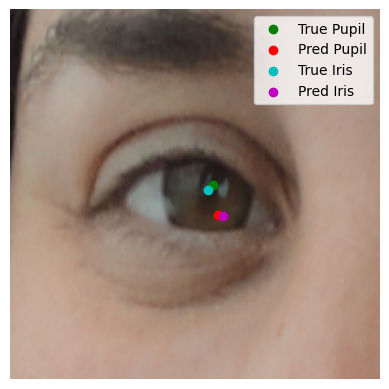

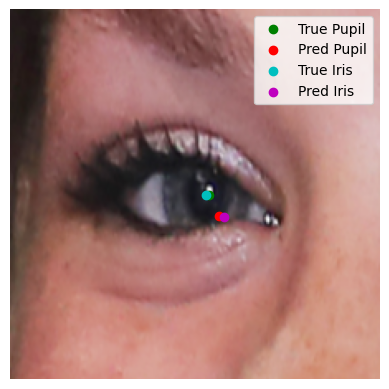

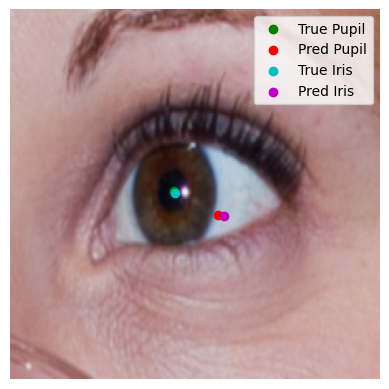

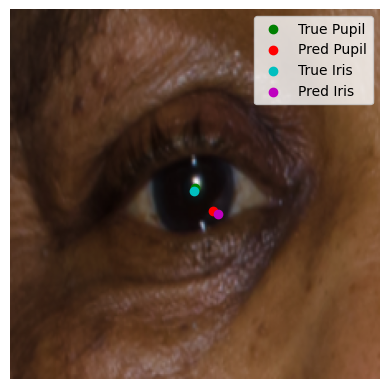

In [ ]:
#visualtion function   
# Uncomment below to visualize predictions on the test set
visualize_predictions(test_dataset, model, device)